***Installing Libraries***

In [1]:
!pip install --quiet pycocotools tqdm opencv-python-headless pillow matplotlib tensorflow

***Downloading Dataset From Kaggle***

In [2]:
import kagglehub
path = kagglehub.dataset_download("awsaf49/coco-2017-dataset")
print("Path to dataset files:", path)

Using Colab cache for faster access to the 'coco-2017-dataset' dataset.
Path to dataset files: /kaggle/input/coco-2017-dataset


***Assigning Values and Dataset Paths***

In [4]:
import os, math, random, sys
import numpy as np
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, Concatenate
from tensorflow.keras.models import Model
from pycocotools.coco import COCO
from tqdm.keras import TqdmCallback

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

TRAIN_IMG_DIR ="/kaggle/input/coco-2017-dataset/coco2017/val2017"
VAL_IMG_DIR   ="/kaggle/input/coco-2017-dataset/coco2017/train2017"
TRAIN_ANN = "/kaggle/input/coco-2017-dataset/coco2017/annotations/instances_val2017.json"
VAL_ANN   = "/kaggle/input/coco-2017-dataset/coco2017/annotations/instances_train2017.json"
TRAIN_N = 7000
VAL_N   = 500
TARGET_SIZE = (128, 128)
BATCH_SIZE = 16
EPOCHS = 20
print("CONFIG:", "TRAIN_N=", TRAIN_N, "VAL_N=", VAL_N,
      "TARGET_SIZE=", TARGET_SIZE, "BATCH_SIZE=", BATCH_SIZE, "EPOCHS=", EPOCHS)

CONFIG: TRAIN_N= 7000 VAL_N= 500 TARGET_SIZE= (128, 128) BATCH_SIZE= 16 EPOCHS= 20


***Load COCO and sample IDs***

In [6]:
try:
    RESAMPLE_HIGH = Image.Resampling.LANCZOS
except Exception:
    try:
        RESAMPLE_HIGH = Image.LANCZOS
    except Exception:
        RESAMPLE_HIGH = Image.BILINEAR
coco_train = COCO(TRAIN_ANN)
coco_val   = COCO(VAL_ANN)

train_all_ids = [i for i in coco_train.getImgIds() if len(coco_train.getAnnIds(imgIds=i))>0]
val_all_ids   = [i for i in coco_val.getImgIds() if len(coco_val.getAnnIds(imgIds=i))>0]

random.shuffle(train_all_ids)
random.shuffle(val_all_ids)

train_ids = train_all_ids[:min(TRAIN_N, len(train_all_ids))]
val_ids   = val_all_ids[:min(VAL_N, len(val_all_ids))]

loading annotations into memory...
Done (t=0.66s)
creating index...
index created!
loading annotations into memory...
Done (t=12.35s)
creating index...
index created!


***Image & mask helpers***

In [7]:
def load_image_by_id(coco, image_id, image_dir, target_size=TARGET_SIZE):
    info = coco.loadImgs(image_id)[0]
    path = os.path.join(image_dir, info['file_name'])
    img = Image.open(path).convert("RGB")
    img = img.resize(target_size, RESAMPLE_HIGH)
    arr = np.array(img).astype(np.float32) / 255.0
    return arr

def build_union_mask(coco, image_id, target_size=TARGET_SIZE):
    ann_ids = coco.getAnnIds(imgIds=image_id, iscrowd=None)
    if not ann_ids:
        return np.zeros(target_size, dtype=np.uint8)
    anns = coco.loadAnns(ann_ids)
    H0 = coco.loadImgs(image_id)[0]['height']
    W0 = coco.loadImgs(image_id)[0]['width']
    union_mask = np.zeros((H0, W0), dtype=np.uint8)
    for a in anns:
        mask = coco.annToMask(a).astype(np.uint8)
        union_mask = np.logical_or(union_mask, mask)
    mask_img = Image.fromarray((union_mask*255).astype('uint8')).resize(target_size, Image.NEAREST)
    mask_arr = (np.array(mask_img) > 127).astype(np.uint8)
    return mask_arr


***Simple Augmentation***

In [8]:
def dataset_from_ids_with_aug(coco, image_dir, ids_list, batch_size=BATCH_SIZE, target_size=TARGET_SIZE, shuffle=True, augment=True):
    def gen():
        idxs = list(ids_list)
        if shuffle:
            random.shuffle(idxs)
        for img_id in idxs:
            img = load_image_by_id(coco, img_id, image_dir, target_size)
            mask = build_union_mask(coco, img_id, target_size)
            if augment and random.random() < 0.5:
                img = np.fliplr(img).copy()
                mask = np.fliplr(mask).copy()
            if augment and random.random() < 0.5:
                factor = 0.7 + random.random()*0.6
                img = np.clip(img * factor, 0.0, 1.0)
            yield img.astype(np.float32), mask[..., None].astype(np.float32)
    out_spec = (tf.TensorSpec(shape=(*target_size,3), dtype=tf.float32),
                tf.TensorSpec(shape=(*target_size,1), dtype=tf.float32))
    ds = tf.data.Dataset.from_generator(gen, output_signature=out_spec)
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = dataset_from_ids_with_aug(coco_train, TRAIN_IMG_DIR, train_ids, batch_size=BATCH_SIZE, shuffle=True, augment=True)
val_ds   = dataset_from_ids_with_aug(coco_val, VAL_IMG_DIR, val_ids, batch_size=BATCH_SIZE, shuffle=False, augment=False)

***Build a U-Net***

In [9]:
def build_unet(input_shape=(*TARGET_SIZE,3)):
    inputs = Input(shape=input_shape)
    c1 = Conv2D(32, 3, padding='same', activation='relu')(inputs)
    c1 = Conv2D(32, 3, padding='same', activation='relu')(c1)
    p1 = MaxPooling2D()(c1)

    c2 = Conv2D(64, 3, padding='same', activation='relu')(p1)
    c2 = Conv2D(64, 3, padding='same', activation='relu')(c2)
    p2 = MaxPooling2D()(c2)

    c3 = Conv2D(128, 3, padding='same', activation='relu')(p2)
    c3 = Conv2D(128, 3, padding='same', activation='relu')(c3)
    p3 = MaxPooling2D()(c3)

    c4 = Conv2D(256, 3, padding='same', activation='relu')(p3)
    c4 = Conv2D(256, 3, padding='same', activation='relu')(c4)

    u5 = Conv2DTranspose(128, 2, strides=2, padding='same')(c4)
    u5 = Concatenate()([u5, c3])
    c5 = Conv2D(128, 3, padding='same', activation='relu')(u5)
    c5 = Conv2D(128, 3, padding='same', activation='relu')(c5)

    u6 = Conv2DTranspose(64, 2, strides=2, padding='same')(c5)
    u6 = Concatenate()([u6, c2])
    c6 = Conv2D(64, 3, padding='same', activation='relu')(u6)
    c6 = Conv2D(64, 3, padding='same', activation='relu')(c6)

    u7 = Conv2DTranspose(32, 2, strides=2, padding='same')(c6)
    u7 = Concatenate()([u7, c1])
    c7 = Conv2D(32, 3, padding='same', activation='relu')(u7)
    c7 = Conv2D(32, 3, padding='same', activation='relu')(c7)

    out = Conv2D(1, 1, activation='sigmoid')(c7)
    model = Model(inputs, out)
    return model

model = build_unet()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      9,248 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │     36,928 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    147,584 │ conv2d_4[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │    295,168 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │    590,080 │ conv2d_6[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 32, 32,    │    131,200 │ conv2d_7[0][0]    │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32, 32,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 256)              │            │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 32, 32,    │    295,040 │ concatenate[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 32, 32,    │    147,584 │ conv2d_8[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 64, 64,    │     32,832 │ conv2d_9[0][0]  

 Total params: 1,925,601 (7.35 MB)

 Trainable params: 1,925,601 (7.35 MB)

 Non-trainable params: 0 (0.00 B)

***BCE + Dice loss And Training***

In [10]:
def dice_coef(y_true, y_pred, eps=1e-7):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2.0 * intersection + eps) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + eps)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    return bce + 1.0 * dice_loss(y_true, y_pred)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=bce_dice_loss,
              metrics=['accuracy'])

import math
steps_per_epoch = math.ceil(len(train_ids) / BATCH_SIZE)
validation_steps = math.ceil(len(val_ids) / BATCH_SIZE)
print("steps_per_epoch:", steps_per_epoch, "validation_steps:", validation_steps)

train_ds_repeat = train_ds.repeat()
val_ds_repeat   = val_ds.repeat()
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("unet_coco_binary_best.keras",
                                       save_best_only=True,
                                       monitor='val_loss'),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
    TqdmCallback(verbose=1)
]

history = model.fit(
    train_ds_repeat,
    validation_data=val_ds_repeat,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=callbacks,
    verbose=0
)

steps_per_epoch: 310 validation_steps: 32


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]


Epoch 16: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.


***Evaluate***

In [11]:
def compute_image_metrics(gt, pred):
    eps = 1e-7
    gt_f = gt.flatten()
    pred_f = pred.flatten()
    pa = np.mean(gt_f == pred_f)
    inter = np.logical_and(gt_f, pred_f).sum()
    uni = np.logical_or(gt_f, pred_f).sum()
    iou = inter / (uni + eps)
    dice = 2 * inter / (gt_f.sum() + pred_f.sum() + eps)
    return pa, dice, iou

pixel_accs, dices, ious = [], [], []
examples = []
max_examples = 6
pred_sums = []

for img_id in val_ids:
    img = load_image_by_id(coco_val, img_id, VAL_IMG_DIR, TARGET_SIZE)
    gt = build_union_mask(coco_val, img_id, TARGET_SIZE)
    prob = model.predict(img[None,...], verbose=0)[0,...,0]
    pred = (prob >= 0.5).astype(np.uint8)
    pred_sums.append(pred.sum())
    pa, di, iu = compute_image_metrics(gt, pred)
    pixel_accs.append(pa); dices.append(di); ious.append(iu)
    if len(examples) < max_examples:
        examples.append((img, gt, pred, prob))

overall_pixel_acc = float(np.mean(pixel_accs))
mean_dice = float(np.mean(dices))
mean_iou = float(np.mean(ious))

print(f"Overall Pixel Accuracy: {overall_pixel_acc:.4f}")
print(f"Mean Dice Coefficient:  {mean_dice:.4f}")
print(f"Mean IoU   :     {mean_iou:.4f}")
print("Validation pred pixel count stats : min, median, mean, max =",
      np.min(pred_sums), np.median(pred_sums), np.mean(pred_sums), np.max(pred_sums))


Overall Pixel Accuracy: 0.8078
Mean Dice Coefficient:  0.6313
Mean IoU   :     0.5046
Validation pred pixel count stats : min, median, mean, max = 0 5146.5 5624.6 15219


***Displaying Results***

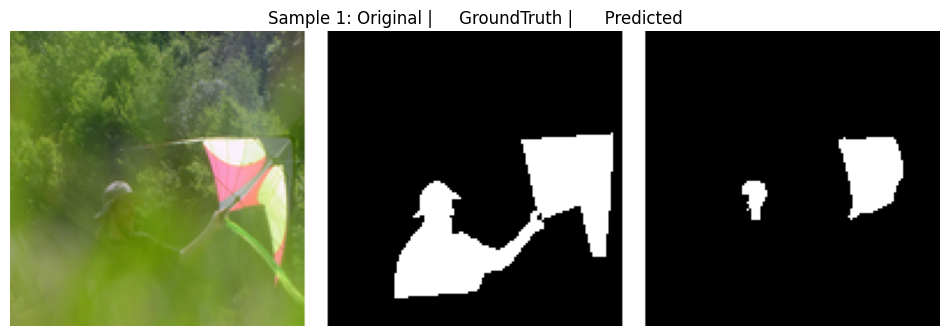

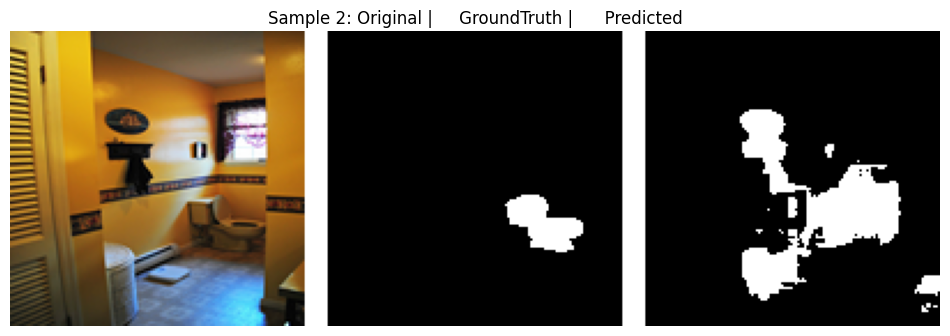

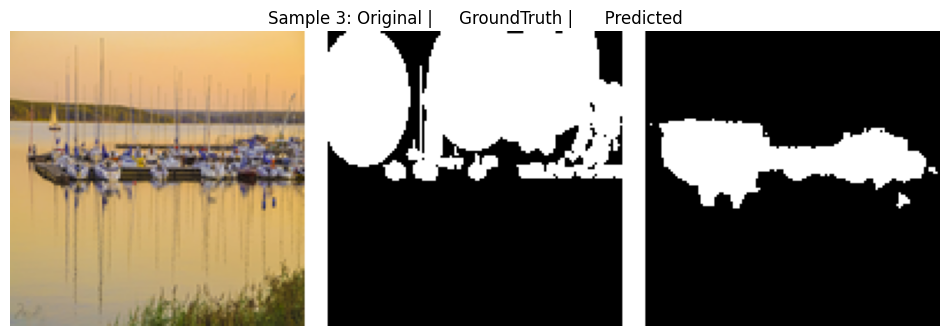

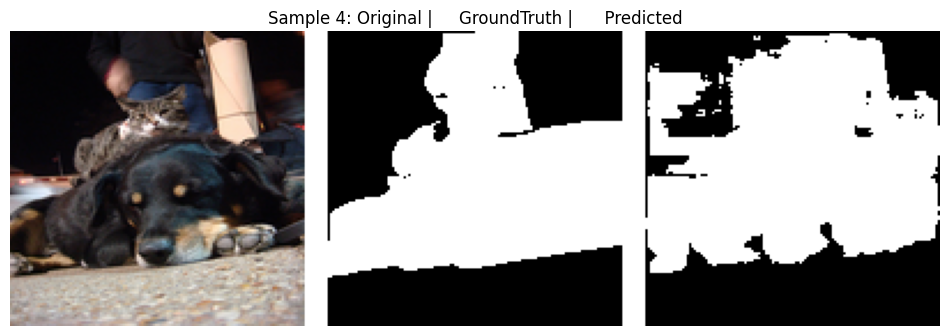

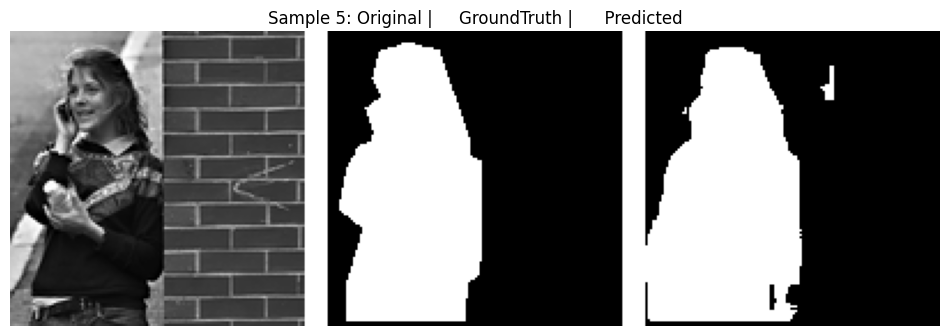

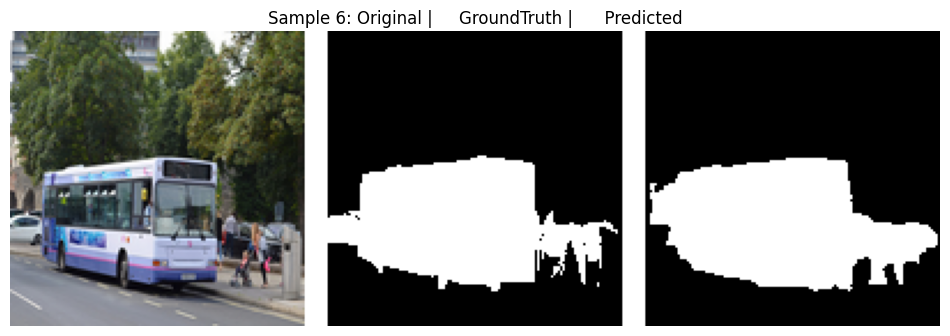

In [12]:
def show_combined_with_gap(img, gt, pr, prob=None, gap_px=10):
    orig = (img * 255).astype('uint8')
    gt3 = np.stack([gt*255, gt*255, gt*255], axis=-1).astype('uint8')
    pr3 = np.stack([pr*255, pr*255, pr*255], axis=-1).astype('uint8')
    gap = np.ones((orig.shape[0], gap_px, 3), dtype='uint8') * 255
    combined = np.concatenate([orig, gap, gt3, gap, pr3], axis=1)
    plt.figure(figsize=(12,4))
    plt.imshow(combined)
    plt.axis('off')

for i, (img, gt, pr, prob) in enumerate(examples):
    show_combined_with_gap(img, gt, pr)
    plt.title(f"Sample {i+1}: Original |     GroundTruth |      Predicted")
plt.show()